# Micromorphic Matrix Form Derivation

We here derive the matrix form of the micromorphic balance equations.

In [1]:
import sympy
import numpy as np

from sympy.utilities.codegen import codegen

sympy.init_printing()

In [2]:
def form_tensor(symbol,shape,isreal=True,isfunction=False,add_open_brace=False,add_close_brace=False,add_braces=False,variables=[]):
    
    if(add_braces):
        add_open_brace = True
        add_close_brace = True
    
    if(add_open_brace):
        symbol += r"{"
    
    if(len(shape)>1):
        return [form_tensor(symbol+str(i+1),shape[1:],\
                            isreal=isreal,isfunction=isfunction,\
                            add_close_brace=add_close_brace,variables=variables)\
                for i in range(shape[0])]
    else:
        
        if add_close_brace:
            cb = r"}"
        else:
            cb = ""
        
        if(isfunction):
            return [sympy.Function(symbol+str(i+1)+cb,real=isreal)(*variables) for i in range(shape[0])]
        else:
            return [sympy.symbols(symbol+str(i+1)+cb,real=isreal) for i in range(shape[0])]
    
def make_symmetric_2(tensor):
    """Make a second order tensor symmetric"""
    for i in range(3):
        for j in range(3):
            tensor[j][i] = tensor[i][j]
            
def make_symmetric_4(tensor,major_symm=False,minor_symm=False):
    """Make a fourth order tensor symmetric"""
    
    if(major_symm):
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    for l in range(3):
                        tensor[k][l][i][j] = tensor[i][j][k][l]
                        
    if(minor_symm):
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    for l in range(3):
                        tensor[j][i][k][l] = tensor[i][j][k][l]
                        tensor[i][j][l][k] = tensor[i][j][k][l]

def tensor_to_voigt_2(A,issymm=False):
    
    if issymm: n = 6
    else:      n = 9
    
    a = [None for _ in range(n)]
    
    a[0] = A[0][0]
    a[1] = A[1][1]
    a[2] = A[2][2]
    a[3] = A[1][2]
    a[4] = A[0][2]
    a[5] = A[0][1]
    
    if not issymm:
        a[6] = A[2][1]
        a[7] = A[2][0]
        a[8] = A[1][0]
        
    return a

def tensor_to_voigt_3(A,asmatrix=False):
    
    if not asmatrix:
        a = [None for _ in range(27)]
    else:
        a = [[None for _ in range(9)] for __ in range(3)]
    
    for i in range(3):
        
        b = tensor_to_voigt_2(A[i])
        
        if not asmatrix:
            a[0+9*i] = b[0]
            a[1+9*i] = b[1]
            a[2+9*i] = b[2]
            a[3+9*i] = b[3]
            a[4+9*i] = b[4]
            a[5+9*i] = b[5]
            a[6+9*i] = b[6]
            a[7+9*i] = b[7]
            a[8+9*i] = b[8]
        else:
            a[i][0] = b[0]
            a[i][1] = b[1]
            a[i][2] = b[2]
            a[i][3] = b[3]
            a[i][4] = b[4]
            a[i][5] = b[5]
            a[i][6] = b[6]
            a[i][7] = b[7]
            a[i][8] = b[8]
        
    return a

def voigt_to_tensor_2(a):
    
    A = [[None for _ in range(3)] for __ in range(3)]
    
    A[0][0] = a[0]
    A[1][1] = a[1]
    A[2][2] = a[2]
    A[1][2] = a[3]
    A[0][2] = a[4]
    A[0][1] = a[5]
    
    if(len(a)==6):
        A[2][1] = a[3]
        A[2][0] = a[4]
        A[1][0] = a[5]
        
    elif(len(a)==9):
        A[2][1] = a[6]
        A[2][0] = a[7]
        A[1][0] = a[8]
        
    else:
        print("Error: incoming vector of incorrect size.\n"+\
              "       Vector is of length: {0}\n".format(len(a))+\
              "       Must be of length 6 or 9.")
        raise IOError
    return A
        
def get_symm_2(A):
    
    half = sympy.S(1)/sympy.S(2)
    
    if(len(A)!=len(A[0])):
        print("Error: Matrix must be square.")
        raise IOError
        
    for i in range(len(A)):
        if(len(A[0])!=len(A[i])):
            print("Error: Matrix columns are inconsistent in length")
            raise IOError
    
    Asymm = form_tensor("A_symm",[len(A),len(A[0])])
    
    for i in range(3):
        for j in range(3):
            Asymm[i][j] = half*(A[i][j]+A[j][i])
            
    return Asymm
            
def get_skew_2(A):
    
    half = sympy.S(1)/sympy.S(2)
    
    if(len(A)!=len(A[0])):
        print("Error: Matrix must be square.")
        raise IOError
        
    for i in range(len(A)):
        if(len(A[0])!=len(A[i])):
            print("Error: Matrix columns are inconsistent in length")
            raise IOError
    
    Askew = form_tensor("A_skew",[len(A),len(A[0])])
    
    for i in range(3):
        for j in range(3):
            Askew = half*(A[i][j]-A[j][i])
            
    return Askew

def pseudo_inverse(A,isright=True):
    
    M = sympy.Matrix(A)
    
    if(isright):
        return M.H * (M * M.H) ** -1
    else:
        return (M.H * M) ** -1 * M.H

In [3]:
"Test the form_tensor function"
A = form_tensor(r'A_',[3,3],add_braces=True)
print(A)
make_symmetric_2(A)
print(A)
B = form_tensor('B',[3,3,3])
print(B)
C = form_tensor('C',[3,3,3,3])
print(C)
make_symmetric_4(C,major_symm=True)
print(C)
print(C[1][2][2][1])
print(C[2][1][1][2])

[[A_{11}, A_{12}, A_{13}], [A_{21}, A_{22}, A_{23}], [A_{31}, A_{32}, A_{33}]]
[[A_{11}, A_{12}, A_{13}], [A_{12}, A_{22}, A_{23}], [A_{13}, A_{23}, A_{33}]]
[[[B111, B112, B113], [B121, B122, B123], [B131, B132, B133]], [[B211, B212, B213], [B221, B222, B223], [B231, B232, B233]], [[B311, B312, B313], [B321, B322, B323], [B331, B332, B333]]]
[[[[C1111, C1112, C1113], [C1121, C1122, C1123], [C1131, C1132, C1133]], [[C1211, C1212, C1213], [C1221, C1222, C1223], [C1231, C1232, C1233]], [[C1311, C1312, C1313], [C1321, C1322, C1323], [C1331, C1332, C1333]]], [[[C2111, C2112, C2113], [C2121, C2122, C2123], [C2131, C2132, C2133]], [[C2211, C2212, C2213], [C2221, C2222, C2223], [C2231, C2232, C2233]], [[C2311, C2312, C2313], [C2321, C2322, C2323], [C2331, C2332, C2333]]], [[[C3111, C3112, C3113], [C3121, C3122, C3123], [C3131, C3132, C3133]], [[C3211, C3212, C3213], [C3221, C3222, C3223], [C3231, C3232, C3233]], [[C3311, C3312, C3313], [C3321, C3322, C3323], [C3331, C3332, C3333]]]]
[[[[C1111

Generate constant values that we need.

In [4]:
zero  = sympy.S(0)
one   = sympy.S(1)
two   = sympy.S(2)
three = sympy.S(3)

half = one/two

#Form the identity tensor|
eye  = [[zero for _ in range(3)] for __ in range(3)]
eye[0][0] = one
eye[1][1] = one
eye[2][2] = one

Now lets test the symmetry functions by computing the stiffness matrix for a linear elastic material

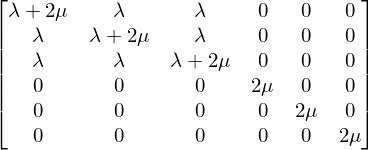

In [5]:
E = form_tensor('E',[3,3])
lamb,mu = sympy.symbols('lambda mu',real=True,positive=True)
make_symmetric_2(E)

sigma = form_tensor('sigma',[3,3])

for I in range(3):
    for J in range(3):
        sigma[I][J] = lamb*eye[I][J]*(E[0][0]+E[1][1]+E[2][2]) + two*mu*E[I][J]

sympy.Matrix(tensor_to_voigt_2(sigma,issymm=True)).jacobian(tensor_to_voigt_2(E,issymm=True))

In [6]:
tensor_to_voigt_3(form_tensor('D',[3,3,3]))

Form the terms which exist in our balance equations

In [7]:
u    = sympy.symbols('u_1 u_2 u_3',real=True)                      #Displacements
v    = sympy.symbols('\dot{u}_1 \dot{u}_2 \dot{u}_3',real=True)    #Velocity
a    = sympy.symbols('\ddot{u}_1 \ddot{u}_2 \ddot{u}_3',real=True) #Accelerations
F    = form_tensor('F',[3,3],isfunction=False,variables=[u])       #Deformation Gradient
rho0 = sympy.symbols('rho0',real=True,positive=True)               #Density in the reference configuration
X    = sympy.symbols('X_1 X_2 X_3')

S    = form_tensor('S',[3,3],isfunction=False,variables=[u])        #PK2 stress
make_symmetric_2(S)
N    = sympy.symbols('N^n',real=True)                              #The shape function
dNdX = form_tensor(r'\frac{dN^{n}}{dX}_',[3],add_braces=True)      #The derivative of the shape function w.r.t. X
Jac  = sympy.symbols('J',real=True,positive=True)                  #Jacobian of transformation
Jhat = sympy.symbols(r'\hat{J}',real=True,positive=True)           #Jacobian of transformation to master coordinates
b    = sympy.symbols('b_1 b_2 b_3',real=True)                      #Body force

## Deformation Measures

Define the deformation measures

In [8]:
RCG    = form_tensor(r"C_",      [3,3],   isreal=True,add_braces=True)
RCGinv = form_tensor(r"C^{-1}_", [3,3],   isreal=True,add_braces=True)
Psi    = form_tensor(r"\Psi_",   [3,3],   isreal=True,add_braces=True)
Gamma  = form_tensor(r"\Gamma_", [3,3,3], isreal=True,add_braces=True)


E     = form_tensor(r"E_", [3,3], isreal=True, add_braces=True)
make_symmetric_2(E)
e     = form_tensor(r"\mathcal{E}_", [3,3],   isreal=True, add_braces=True)

#for I in range(3):
#    for J in range(3):
#        E[I][J] = half*(RCG[I][J] - eye[I][J])
#        e[I][J] = Psi[I][J] - eye[I][J]

## Linear Isotropic Elasticity Stress Measures

Compute the stress measures

In [9]:
lamb,mu,eta,tau,kappa,nu,sigma = sympy.symbols('lambda mu eta tau kappa nu sigma',real=True)
tau1,tau2,tau3,tau4,tau5,tau6,tau7,tau8,tau9,tau10,tau11 = sympy.symbols('tau1 tau2 tau3 tau4 tau5 tau6 tau7 tau8 tau9 tau10 tau11',real=True)

A = form_tensor(r'\mathcal{A}',[3,3,3,3],     isreal=True)
B = form_tensor(r'\mathcal{B}',[3,3,3,3],     isreal=True)
C = form_tensor(r'\mathcal{C}',[3,3,3,3,3,3], isreal=True)
D = form_tensor(r'\mathcal{D}',[3,3,3,3],     isreal=True)

In [10]:
for k in range(3):
    for l in range(3):
        for m in range(3):
            for n in range(3):
                A[k][l][m][n] = lamb*eye[k][l]*eye[m][n] + mu*(eye[k][m]*eye[l][n] + eye[k][n]*eye[l][m])
                B[k][l][m][n] = (eta-tau)*eye[k][l]*eye[m][n] + kappa*eye[k][m]*eye[l][n] + nu*eye[k][n]*eye[l][m]\
                                - sigma*(eye[k][m]*eye[l][n] + eye[k][n]*eye[l][m])
                    
                for p in range(3):
                    for q in range(3):
                        C[k][l][m][n][p][q] =  tau1*(eye[k][l]*eye[m][n]*eye[p][q] + eye[k][q]*eye[l][m]*eye[n][p])\
                                              +tau2*(eye[k][l]*eye[m][p]*eye[n][q] + eye[k][m]*eye[l][q]*eye[n][p])\
                                              +tau3*eye[k][l]*eye[m][q]*eye[n][p]  + tau4*eye[k][n]*eye[l][m]*eye[p][q]\
                                              +tau5*(eye[k][m]*eye[l][n]*eye[p][q] + eye[k][p]*eye[l][m]*eye[n][q])\
                                              +tau6*eye[k][m]*eye[l][p]*eye[n][q]  + tau7*eye[k][n]*eye[l][p]*eye[m][q]\
                                              +tau8*(eye[k][p]*eye[l][q]*eye[m][n] + eye[k][q]*eye[l][n]*eye[m][p])\
                                              +tau9*eye[k][n]*eye[l][q]*eye[m][p]  + tau10*eye[k][p]*eye[l][n]*eye[m][q]\
                                              +tau11*eye[k][q]*eye[l][p]*eye[m][n]
                                            
                D[k][l][m][n] = tau*eye[k][l]*eye[m][n] + sigma*(eye[k][m]*eye[l][n]+eye[k][n]*eye[l][m])

### PK2 Stress tensor

Form a matrix-multiplication form of the PK2 stress tensor

#ifndef PROJECT__TEST__H
#define PROJECT__TEST__H
void compute_A_voigt(double lambda, double mu, double *out_3510267651275309286);
#endif

#include "test.h"
#include <math.h>
void compute_A_voigt(double lambda, double mu, double *out_3510267651275309286) {
   out_3510267651275309286[0] = lambda + 2*mu;
   out_3510267651275309286[1] = lambda;
   out_3510267651275309286[2] = lambda;
   out_3510267651275309286[3] = 0;
   out_3510267651275309286[4] = 0;
   out_3510267651275309286[5] = 0;
   out_3510267651275309286[6] = 0;
   out_3510267651275309286[7] = 0;
   out_3510267651275309286[8] = 0;
   out_3510267651275309286[9] = lambda;
   out_3510267651275309286[10] = lambda + 2*mu;
   out_3510267651275309286[11] = lambda;
   out_3510267651275309286[12] = 0;
   out_3510267651275309286[13] = 0;
   out_3510267651275309286[14] = 0;
   out_3510267651275309286[15] = 0;
   out_3510267651275309286[16] = 0;
   out_3510267651275309286[17] = 0;
   out_3510267651275309286[18] = lambda;
   out_3510267651275

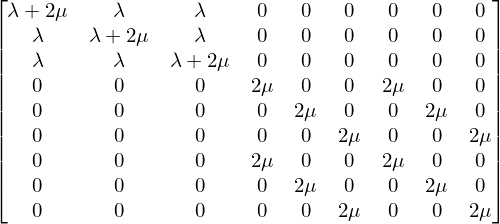

In [11]:
term1  = form_tensor('term1',  [3,3], isreal=True)
term2  = form_tensor('term2',  [3,3], isreal=True)
term3  = form_tensor('term4',  [3,3], isreal=True)
term4  = form_tensor('term4',  [3,3], isreal=True)
term5  = form_tensor('term5',  [3,3], isreal=True)

temp1  = form_tensor('temp1', [3,3],   isreal=True)
temp2  = form_tensor('temp2', [3,3],   isreal=True)
temp3  = form_tensor('temp3', [3,3],   isreal=True)
temp4  = form_tensor('temp4', [3,3,3], isreal=True)
temp5  = form_tensor('temp5', [3,3,3], isreal=True)

T3     = form_tensor(r"T_",           [3,3],   isreal=True, add_braces=True)
T4     = form_tensor(r"\mathcal{T}_", [3,3,3], isreal=True, add_braces=True)

for i in range(3):
    for j in range(3):
        
        term1[i][j]  = zero
        term2[i][j]  = zero
        temp1[i][j] = zero
        temp2[i][j] = zero
        
        for k in range(3):
            for l in range(3):
                term1[i][j] += A[i][j][k][l]*E[k][l]
                term2[i][j] += D[i][j][k][l]*e[k][l]
                temp1[i][j] += B[i][j][k][l]*e[k][l]
                temp2[i][j] += D[i][j][k][l]*E[k][l]
                
for j in range(3):
    for q in range(3):
        
        temp3[j][q] = zero
        
        for t in range(3):
            temp3[j][q] += RCGinv[t][j]*Psi[t][q]

for j in range(3):
    for q in range(3):
        for r in range(3):
            temp4[j][q][r] = zero
            
            for s in range(3):
                temp4[j][q][r] += RCGinv[j][s]*Gamma[s][q][r]
            
for i in range(3):
    for j in range(3):
        
        term3[i][j] = zero
        term4[i][j] = zero
        
        for q in range(3):
            for r in range(3):
                term3[i][j] += temp1[i][q]*T3[j][q]
                term4[i][j] += temp2[i][q]*T3[j][q]
            
for i in range(3):
    for q in range(3):
        for r in range(3):
            temp5[i][q][r] = zero
            
            for l in range(3):
                for m in range(3):
                    for n in range(3):
                        temp5[i][q][r] += C[i][q][r][l][m][n]*Gamma[l][m][n]
                        
for i in range(3):
    for j in range(3):
        term5[i][j] = zero
        
        for q in range(3):
            for r in range(3):
                term5[i][j] += temp5[i][q][r]*T4[j][q][r]
                        
                
            
E_voigt      = tensor_to_voigt_2(E,        issymm=False)
e_voigt      = tensor_to_voigt_2(e,        issymm=False)
temp3_voigt  = tensor_to_voigt_2(temp3,    issymm=False)
T3_voigt     = tensor_to_voigt_2(T3,       issymm=False)
T4_voigt     = tensor_to_voigt_3(T4)
RCGinv_voigt = tensor_to_voigt_2(RCGinv,   issymm=True)
Gamma_voigt  = tensor_to_voigt_3(Gamma)
            
term1_matrix = sympy.Matrix(tensor_to_voigt_2(term1,issymm=False)).jacobian(E_voigt)
term2_matrix = sympy.Matrix(tensor_to_voigt_2(term2,issymm=False)).jacobian(e_voigt)
term3_matrix = sympy.Matrix(tensor_to_voigt_2(term3,issymm=False)).jacobian(e_voigt)
term4_matrix = sympy.Matrix(tensor_to_voigt_2(term4,issymm=False)).jacobian(E_voigt)
term5_matrix = sympy.Matrix(tensor_to_voigt_2(term5,issymm=False)).jacobian(Gamma_voigt)
B_voigt = sympy.Matrix(tensor_to_voigt_2(temp1)).jacobian(e_voigt)
C_voigt = sympy.Matrix(tensor_to_voigt_3(temp5)).jacobian(Gamma_voigt)
D_voigt = sympy.Matrix(tensor_to_voigt_2(temp2)).jacobian(E_voigt)
#C_voigt
#Print the A stiffness tensor in voigt notation
A_voigt = term1_matrix
[(c_name, c_code), (h_name, c_header)] = codegen(("compute_A_voigt", A_voigt), "C", "test", header=False, empty=False)
print(c_header)
print(c_code)
#Print the B stiffness tensor in voigt notation
[(c_name, c_code), (h_name, c_header)] = codegen(("compute_B_voigt", B_voigt), "C", "test", header=False, empty=False)
print(c_header)
print(c_code)
#Print the C stiffness tensor in voigt notation
[(c_name, c_code), (h_name, c_header)] = codegen(("compute_C_voigt", C_voigt), "C", "test", header=False, empty=False)
print(c_header)
print(c_code)
#Print the D stiffness tensor in voigt notation
[(c_name, c_code), (h_name, c_header)] = codegen(("compute_D_voigt", D_voigt), "C", "test", header=False, empty=False)
print(c_header)
print(c_code)

term1_matrix
#sympy.Matrix(tensor_to_voigt_2(term3,issymm=False)).jacobian(tensor_to_voigt_2(tensor_to_voigt_2(e,issymm=True)))

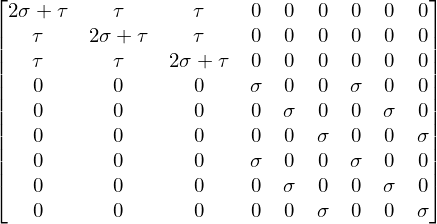

In [12]:
term2_matrix

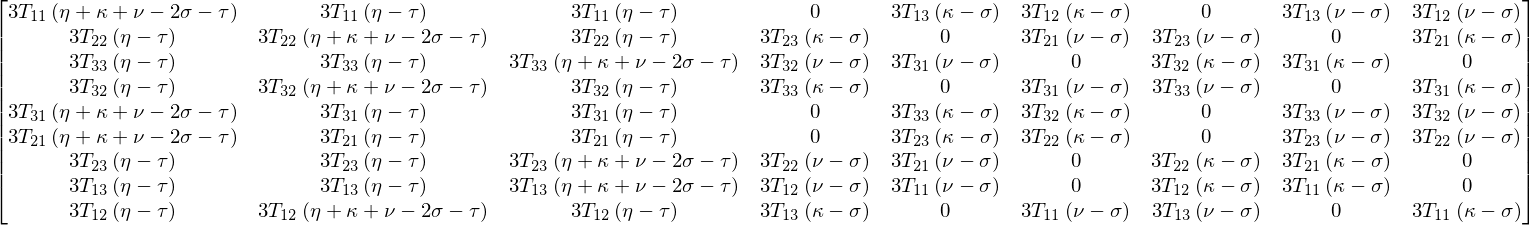

In [13]:
term3_matrix

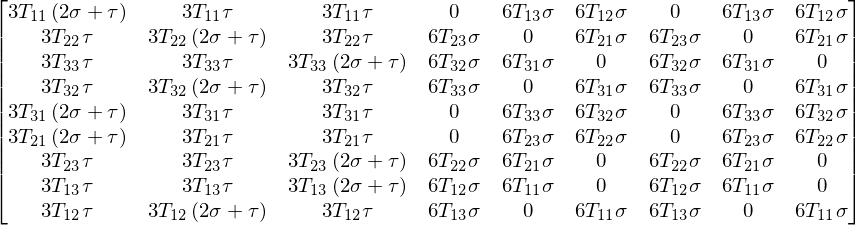

In [14]:
term4_matrix

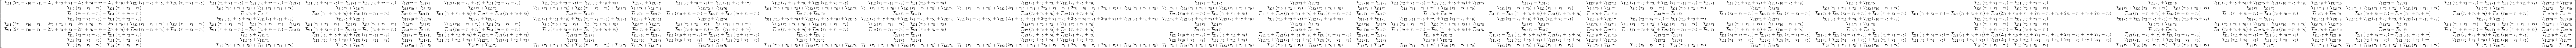

In [15]:
term5_matrix

## Symmetric Stress

The formulation of the symmetric stress tensor is identical to the Cauchy stress except we only take the symmetric parts of terms 3, 4, and 5.

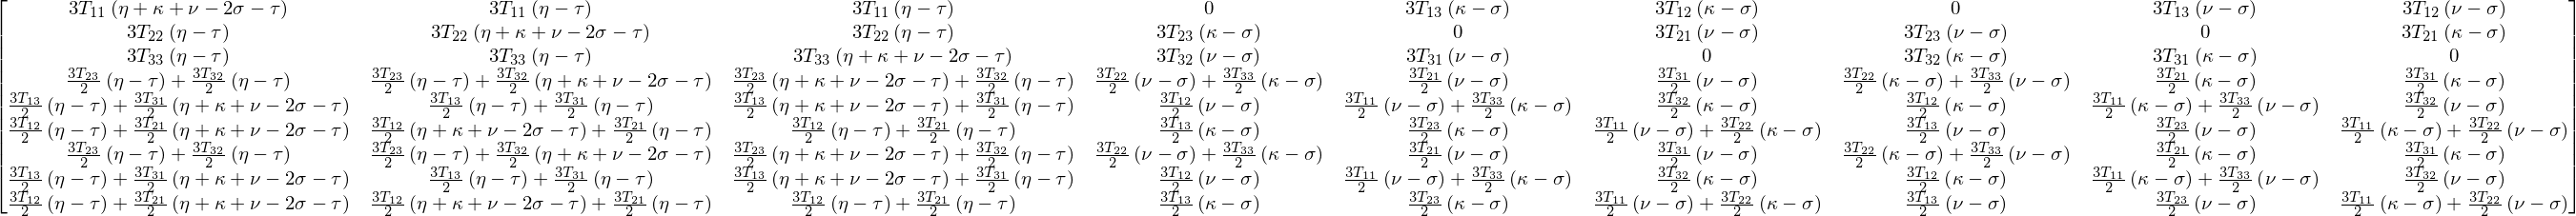

In [16]:
term3_symm = get_symm_2(term3)
term4_symm = get_symm_2(term4)
term5_symm = get_symm_2(term5)

term3_symm_matrix = sympy.Matrix(tensor_to_voigt_2(term3_symm,issymm=False)).jacobian(e_voigt)
term4_symm_matrix = sympy.Matrix(tensor_to_voigt_2(term4_symm,issymm=False)).jacobian(E_voigt)
term5_symm_matrix = sympy.Matrix(tensor_to_voigt_2(term5_symm,issymm=False)).jacobian(Gamma_voigt)
term3_symm_matrix

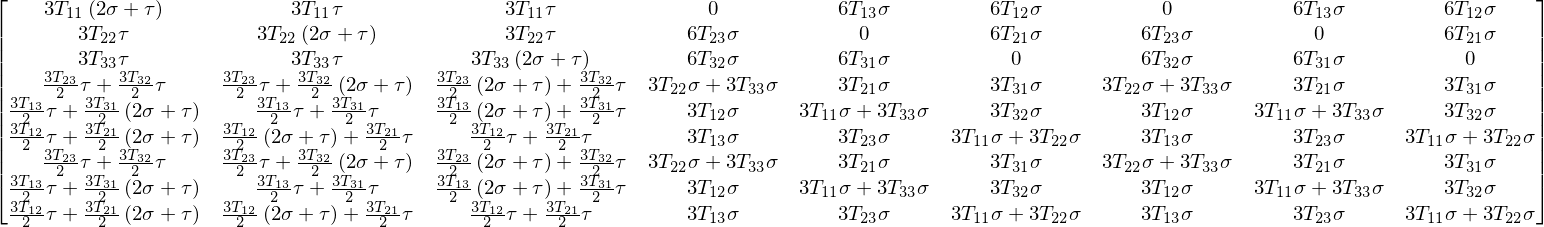

In [17]:
term4_symm_matrix

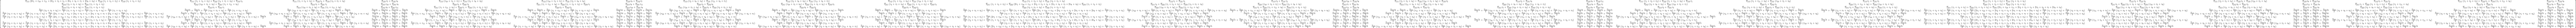

In [18]:
term5_symm_matrix

## Balance of Linear Momentum

Put the balance of linear momentum and its gradient into matrix form

In [19]:
fint = [zero for _ in range(3)]
for j in range(3):
    for I in range(3):
        for J in range(3):
            fint[j] += S[I][J]*Jhat*dNdX[I]*F[j][J]
        
fext = [zero for _ in range(3)]

for j in range(3):
    for I in range(3):
        for J in range(3):
            fext[j] += N*F[j][J]*S[I][J]*Jhat*dNdX[I]+N*rho0*b[j]*Jhat
            
fkin = [zero for _ in range(3)]

for j in range(3):
    fkin[j] += N*rho0*a[j]*Jhat

In [20]:
tmp1 = sympy.Matrix(fint).jacobian(tensor_to_voigt_2(F,issymm=False))
tmp1
[sympy.Matrix([v]).jacobian(dNdX) for v in tmp1]

In [21]:
from sympy.utilities.codegen import codegen
t = sympy.symbols('t')
[(c_name, c_code), (h_name, c_header)] = codegen(("compute_C_voigt", ['a',C_voigt]), "C", "test", header=False, empty=False)
print(c_header)
print(c_code)

#ifndef PROJECT__TEST__H
#define PROJECT__TEST__H
double compute_C_voigt(double a, double tau1, double tau10, double tau11, double tau2, double tau3, double tau4, double tau5, double tau6, double tau7, double tau8, double tau9, double *out_2444107206997055765);
#endif

#include "test.h"
#include <math.h>
double compute_C_voigt(double a, double tau1, double tau10, double tau11, double tau2, double tau3, double tau4, double tau5, double tau6, double tau7, double tau8, double tau9, double *out_2444107206997055765) {
   out_2444107206997055765[0] = 2*tau1 + tau10 + tau11 + 2*tau2 + tau3 + tau4 + 2*tau5 + tau6 + tau7 + 2*tau8 + tau9;
   out_2444107206997055765[1] = tau1 + tau4 + tau5;
   out_2444107206997055765[2] = tau1 + tau4 + tau5;
   out_2444107206997055765[3] = 0;
   out_2444107206997055765[4] = 0;
   out_2444107206997055765[5] = 0;
   out_2444107206997055765[6] = 0;
   out_2444107206997055765[7] = 0;
   out_2444107206997055765[8] = 0;
   out_2444107206997055765[9] = 0;
   out_2444107

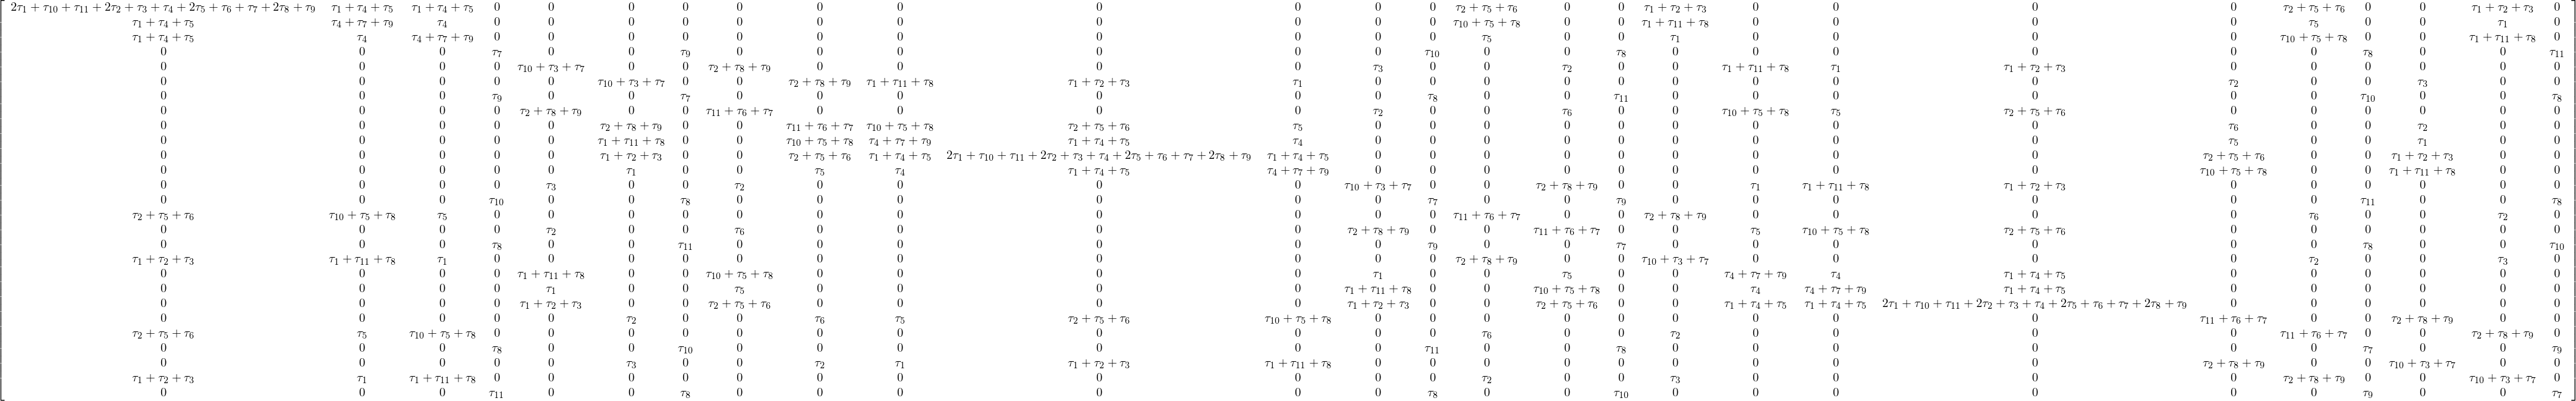

In [22]:
C_voigt

## Balance of the First Moment of Momentum

Put the balance of the first moment of momentum in matrix form.

Now we will define the gradients of the deformation measures

In [23]:
Gamma_mat = form_tensor(r'\Gamma_',[3,3,3],add_braces=True)
grad_chi  = form_tensor(r'\frac{\partial\chi}{\partial\ X}_',[3,3,3],add_braces=True)

for icap in range(3):
    for l in range(3):
        for j in range(3):
            Gamma_mat[icap][l][j] = zero
            for i in range(3):
                Gamma_mat[icap][l][j] += F[i][icap]*grad_chi[i][l][j]
Gamma_voigt = tensor_to_voigt_3(Gamma_mat)

temp_mat = [None for _ in range(3)]

for i in range(3):
    temp_mat[i] = [v for v in tensor_to_voigt_2(grad_chi[i])]
    
Alt_gamma = [[None for __ in range(9)] for _ in range(3)]
for i in range(3):
    for j in range(9):
        tmp = zero
        
        for k in range(3):
            tmp += F[k][i]*temp_mat[k][j]
            
        Alt_gamma[i][j] = tmp
tmp_Gamma = [Gamma_voigt[(i*9):(i+1)*9] for i in range(3)]
[[tmp_Gamma[i][j] - Alt_gamma[i][j] for j in range(9)] for i in range(3)]

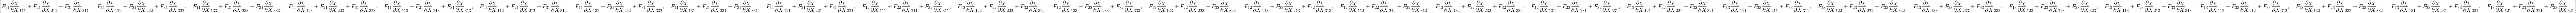

In [24]:
Gamma_voigt

In [25]:
np.random.seed(123)
grad_u = np.array([np.random.rand(3) for _ in range(3)])

print(grad_u)

Ftest_inv = (np.eye(3) - grad_u)
Ftest     = np.linalg.inv(Ftest_inv)
print(Ftest)

[[0.69646919 0.28613933 0.22685145]
 [0.55131477 0.71946897 0.42310646]
 [0.9807642  0.68482974 0.4809319 ]]
[[ 0.36729636 -0.77433925 -0.47066315]
 [-1.78661838  0.16546451 -0.64594197]
 [-1.6631696  -1.24478696  0.18500493]]


In [26]:
grad_u.flatten()

array([0.69646919, 0.28613933, 0.22685145, 0.55131477, 0.71946897,
       0.42310646, 0.9807642 , 0.68482974, 0.4809319 ])

In [27]:
phi = np.random.rand(9)
grad_phi = np.array([[np.random.rand(3) for _ in range(3)] for __ in range(3)])
print(phi.flatten())

phi_ten = np.array(voigt_to_tensor_2(phi))
print(phi_ten)
chi = phi_ten + np.eye(3)
print(chi.flatten())

[0.39211752 0.34317802 0.72904971 0.43857224 0.0596779  0.39804426
 0.73799541 0.18249173 0.17545176]
[[0.39211752 0.39804426 0.0596779 ]
 [0.17545176 0.34317802 0.43857224]
 [0.18249173 0.73799541 0.72904971]]
[1.39211752 0.39804426 0.0596779  0.17545176 1.34317802 0.43857224
 0.18249173 0.73799541 1.72904971]


In [28]:
grad_phi

array([[[0.53155137, 0.53182759, 0.63440096],
        [0.84943179, 0.72445532, 0.61102351],
        [0.72244338, 0.32295891, 0.36178866]],

       [[0.22826323, 0.29371405, 0.63097612],
        [0.09210494, 0.43370117, 0.43086276],
        [0.4936851 , 0.42583029, 0.31226122]],

       [[0.42635131, 0.89338916, 0.94416002],
        [0.50183668, 0.62395295, 0.1156184 ],
        [0.31728548, 0.41482621, 0.86630916]]])

In [29]:
grad_phi_map = np.zeros([3,3,3])

for i in range(3):
    for I in range(3):
        for J in range(3):
            
            for j in range(3):
                grad_phi_map[i][I][J] += grad_phi[i][I][j] * Ftest[j][J]

temp_mat = np.array([tensor_to_voigt_2(v) for v in grad_phi_map])

In [30]:
temp_mat.flatten()

array([-1.81005245, -1.29847083, -0.48170751, -0.75470999, -0.4763441 ,
       -1.11329654, -0.95632783, -0.9133694 , -1.99856773, -1.49033497,
       -0.53589066, -0.44965118, -0.24378446, -0.18042363, -0.91358478,
       -0.70051865, -1.09881086, -1.45762653, -3.00984646, -0.42927004,
       -0.25701678, -0.61784346, -0.60307115, -1.35759442, -1.25541793,
       -2.06541739, -1.12273603])

In [31]:
temp_mat.shape

In [32]:
np.array([grad_phi[0,0],grad_phi[1,1],grad_phi[2,2],grad_phi[1,2],grad_phi[0,2],grad_phi[0,1],grad_phi[2,1],grad_phi[2,0],grad_phi[1,0]]).flatten()

array([0.53155137, 0.53182759, 0.63440096, 0.09210494, 0.43370117,
       0.43086276, 0.31728548, 0.41482621, 0.86630916, 0.4936851 ,
       0.42583029, 0.31226122, 0.72244338, 0.32295891, 0.36178866,
       0.84943179, 0.72445532, 0.61102351, 0.50183668, 0.62395295,
       0.1156184 , 0.42635131, 0.89338916, 0.94416002, 0.22826323,
       0.29371405, 0.63097612])

In [39]:
#Print code for A_voigt
n = 0
for i in range(A_voigt.shape[0]):
    for j in range(A_voigt.shape[1]):
        if A_voigt[i,j] != zero:
            print(r"        tripletList.push_back({0},{1},{2});".format(i,j,A_voigt[i,j]))
            n += 1
print(n)

        tripletList.push_back(0,0,lambda + 2*mu);
        tripletList.push_back(0,1,lambda);
        tripletList.push_back(0,2,lambda);
        tripletList.push_back(1,0,lambda);
        tripletList.push_back(1,1,lambda + 2*mu);
        tripletList.push_back(1,2,lambda);
        tripletList.push_back(2,0,lambda);
        tripletList.push_back(2,1,lambda);
        tripletList.push_back(2,2,lambda + 2*mu);
        tripletList.push_back(3,3,2*mu);
        tripletList.push_back(3,6,2*mu);
        tripletList.push_back(4,4,2*mu);
        tripletList.push_back(4,7,2*mu);
        tripletList.push_back(5,5,2*mu);
        tripletList.push_back(5,8,2*mu);
        tripletList.push_back(6,3,2*mu);
        tripletList.push_back(6,6,2*mu);
        tripletList.push_back(7,4,2*mu);
        tripletList.push_back(7,7,2*mu);
        tripletList.push_back(8,5,2*mu);
        tripletList.push_back(8,8,2*mu);
21


In [40]:
#Print code for B_voigt
n = 0
for i in range(B_voigt.shape[0]):
    for j in range(B_voigt.shape[1]):
        if B_voigt[i,j] != zero:
            print(r"        tripletList.push_back({0},{1},{2});".format(i,j,B_voigt[i,j]))
            n += 1
print(n)

        tripletList.push_back(0,0,eta + kappa + nu - 2*sigma - tau);
        tripletList.push_back(0,1,eta - tau);
        tripletList.push_back(0,2,eta - tau);
        tripletList.push_back(1,0,eta - tau);
        tripletList.push_back(1,1,eta + kappa + nu - 2*sigma - tau);
        tripletList.push_back(1,2,eta - tau);
        tripletList.push_back(2,0,eta - tau);
        tripletList.push_back(2,1,eta - tau);
        tripletList.push_back(2,2,eta + kappa + nu - 2*sigma - tau);
        tripletList.push_back(3,3,kappa - sigma);
        tripletList.push_back(3,6,nu - sigma);
        tripletList.push_back(4,4,kappa - sigma);
        tripletList.push_back(4,7,nu - sigma);
        tripletList.push_back(5,5,kappa - sigma);
        tripletList.push_back(5,8,nu - sigma);
        tripletList.push_back(6,3,nu - sigma);
        tripletList.push_back(6,6,kappa - sigma);
        tripletList.push_back(7,4,nu - sigma);
        tripletList.push_back(7,7,kappa - sigma);
        tripletList.push_back(8,

In [41]:
#Print code for C_voigt
n = 0
for i in range(C_voigt.shape[0]):
    for j in range(C_voigt.shape[1]):
        if C_voigt[i,j] != zero:
            print(r"        tripletList.push_back({0},{1},{2});".format(i,j,C_voigt[i,j]))
            n += 1
print(n)

        tripletList.push_back(0,0,2*tau1 + tau10 + tau11 + 2*tau2 + tau3 + tau4 + 2*tau5 + tau6 + tau7 + 2*tau8 + tau9);
        tripletList.push_back(0,1,tau1 + tau4 + tau5);
        tripletList.push_back(0,2,tau1 + tau4 + tau5);
        tripletList.push_back(0,14,tau2 + tau5 + tau6);
        tripletList.push_back(0,17,tau1 + tau2 + tau3);
        tripletList.push_back(0,22,tau2 + tau5 + tau6);
        tripletList.push_back(0,25,tau1 + tau2 + tau3);
        tripletList.push_back(1,0,tau1 + tau4 + tau5);
        tripletList.push_back(1,1,tau4 + tau7 + tau9);
        tripletList.push_back(1,2,tau4);
        tripletList.push_back(1,14,tau10 + tau5 + tau8);
        tripletList.push_back(1,17,tau1 + tau11 + tau8);
        tripletList.push_back(1,22,tau5);
        tripletList.push_back(1,25,tau1);
        tripletList.push_back(2,0,tau1 + tau4 + tau5);
        tripletList.push_back(2,1,tau4);
        tripletList.push_back(2,2,tau4 + tau7 + tau9);
        tripletList.push_back(2,14,tau5);
   

In [42]:
#Print code for D_voigt
n = 0
for i in range(D_voigt.shape[0]):
    for j in range(D_voigt.shape[1]):
        if D_voigt[i,j] != zero:
            print(r"        tripletList.push_back({0},{1},{2});".format(i,j,D_voigt[i,j]))
            n += 1
print(n)

        tripletList.push_back(0,0,2*sigma + tau);
        tripletList.push_back(0,1,tau);
        tripletList.push_back(0,2,tau);
        tripletList.push_back(1,0,tau);
        tripletList.push_back(1,1,2*sigma + tau);
        tripletList.push_back(1,2,tau);
        tripletList.push_back(2,0,tau);
        tripletList.push_back(2,1,tau);
        tripletList.push_back(2,2,2*sigma + tau);
        tripletList.push_back(3,3,2*sigma);
        tripletList.push_back(3,6,2*sigma);
        tripletList.push_back(4,4,2*sigma);
        tripletList.push_back(4,7,2*sigma);
        tripletList.push_back(5,5,2*sigma);
        tripletList.push_back(5,8,2*sigma);
        tripletList.push_back(6,3,2*sigma);
        tripletList.push_back(6,6,2*sigma);
        tripletList.push_back(7,4,2*sigma);
        tripletList.push_back(7,7,2*sigma);
        tripletList.push_back(8,5,2*sigma);
        tripletList.push_back(8,8,2*sigma);
21


In [37]:
temp3

In [38]:
tmp = np.array(range(27)).reshape([3,3,3])

swap = np.zeros([3,3,3]).astype(int)

for i in range(3):
    for j in range(3):
        for k in range(3):
            swap[j,k,i] = tmp[i,j,k]
print(tensor_to_voigt_3(tmp))
print(tensor_to_voigt_3(swap))

[0, 4, 8, 5, 2, 1, 7, 6, 3, 9, 13, 17, 14, 11, 10, 16, 15, 12, 18, 22, 26, 23, 20, 19, 25, 24, 21]
[0, 10, 20, 19, 18, 9, 11, 2, 1, 3, 13, 23, 22, 21, 12, 14, 5, 4, 6, 16, 26, 25, 24, 15, 17, 8, 7]
